## ch04-사이킷런을 활용한 mlflow

<div style="text-align: right"> Initial upload: 2022.04.05 </div>
<div style="text-align: right"> Last update: 2022.04.05</div>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 50

from pylab import rcParams

rcParams['figure.figsize'] = 14, 8

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

In [30]:
import mlflow
import mlflow.sklearn

In [31]:
df = pd.read_csv('data/creditcard.csv')
df = df.drop('Time', axis = 1)

In [32]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


정상, 비정상 분할하기

In [33]:
normal = df[df['Class']==0].sample(frac= 0.5, random_state=2020).reset_index(drop = True)
anomaly = df[df['Class']==1]

In [34]:
print(f'Normal: {normal.shape}')
print(f'Anormal: {anomaly.shape}')

Normal: (142158, 30)
Anormal: (492, 30)


데이터셋 분할

In [35]:
normal_train, normal_test = train_test_split(normal, test_size=.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [36]:
X_train = pd.concat((normal_train, anomaly_train))
X_test = pd.concat((normal_test, anomaly_test))
X_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(X_train['Class'])
y_test = np.array(X_test['Class'])
y_validate = np.array(X_validate['Class'])

X_train = X_train.drop('Class', axis = 1)
X_test = X_test.drop('Class', axis = 1)
X_validate = X_validate.drop('Class', axis = 1)

In [37]:
print(X_train.shape)
print(y_train.shape)

(85588, 29)
(85588,)


In [38]:
print(X_test.shape)
print(y_test.shape)

(28531, 29)
(28531,)


In [39]:
print(X_validate.shape)
print(y_validate.shape)

(28531, 29)
(28531,)


스케일러

In [40]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis = 1))

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validate = scaler.transform(X_validate)

### MLFlow를 통한 학습 및 평가

학습함수 구현하기

In [41]:
def train(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric('train_acc', train_acc) # mlflow에서 기록할 지표 정의
    print(f'Training Accuracy: {train_acc: .3%}')

평가함수 구현하기

In [44]:
def evaluate(sk_model, X_test, y_test):
    eval_acc = sk_model.score(X_test, y_test)
    preds = sk_model.predict(X_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric('eval_acc', eval_acc) # 지표 로깅
    mlflow.log_metric('auc_score', auc_score)
    
    print(f'Auc Score: {auc_score: .3%}')
    print(f'Eval Score: {eval_acc: .3%}')
    roc_plot = plot_roc_curve(sk_model, X_test, y_test, name = 'scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig('sklearn_conf_matrix.png')
    
    mlflow.log_artifact("sklearn_roc_plot.png") # 평가 이미지도 로깅
    mlflow.log_artifact("sklearn_conf_matrix.png")

### MLFlow 실행 로깅 및 확인

Training Accuracy:  99.893%
Auc Score:  85.341%
Eval Score:  99.874%


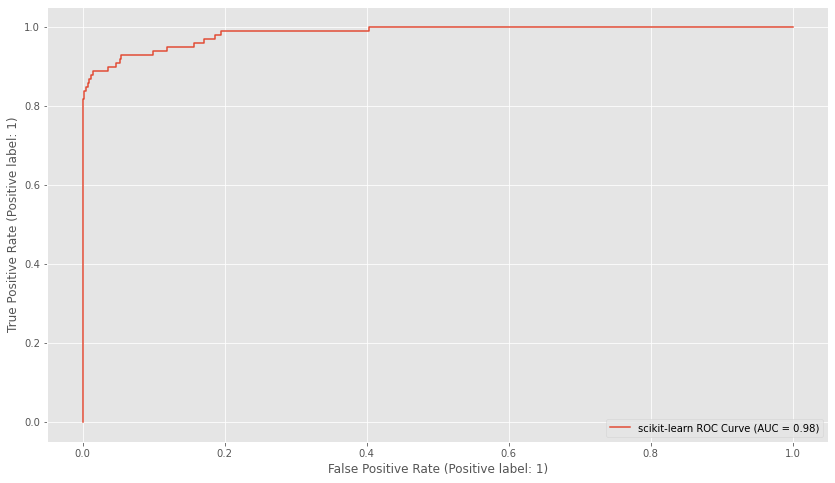

2022/04/11 15:57:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\KM24A6~1.YU9\AppData\Local\Temp\tmpv6u_l1fb\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Model run:  0260eca333f247fc8ff6c57ef965c61a


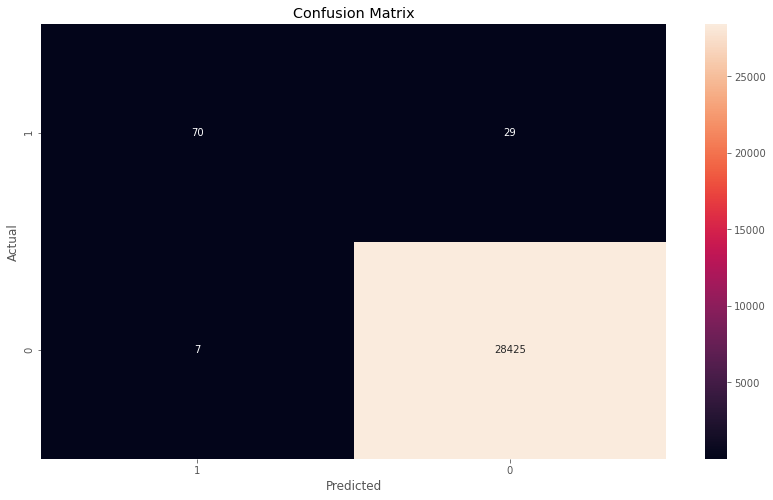

In [45]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver = 'newton-cg')

mlflow.set_experiment('scikit_learn_experiment') # 실험 설정  
with mlflow.start_run():
    train(sk_model, X_train, y_train)
    evaluate(sk_model, X_test, y_test)
    mlflow.sklearn.log_model(sk_model, 'log_reg_model')# Pyspark 모델을 로깅하려명 mlfow.spark를 실행하면 된다.
    print('Model run: ', mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [46]:
!mlflow ui -p 1234

^C


### 로깅된 모델 로드

모델을 로드하려면 mlflow ui나 폴더에서 실행ID(Run ID)를 알아야 한다.

In [48]:
loaded_model = mlflow.sklearn.load_model('runs:/0260eca333f247fc8ff6c57ef965c61a/log_reg_model')

In [49]:
loaded_model

LogisticRegression(max_iter=400, solver='newton-cg')

모델 사용해보기

In [50]:
loaded_model.score(X_test, y_test)

0.9987382145736217

### MLFlow를 사용한 모델 검증(파라미터 튜닝)

#### 그리드서치

In [51]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [52]:
mlflow.set_experiment('sklearn_creditcard_broad_search')
logs = []

for f in range((len(anomaly_weights))):
    fold = 1
    accuracies = []
    auc_scores = []
    
    for train, test in kfold.split(X_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param('anomaly_weight', weight)
            class_weights = {0: 1, 1: weight}
            
            sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg',
                                         class_weight=class_weights).fit(X_validate[train], y_validate[train])
            
            for h in range(40): print('-', end="")
            
            print(f'\nflod {fold}\nAnomaly Weight: {weight}')
            train_acc = sk_model.score(X_validate[train], y_validate[train])
            mlflow.log_metric('train_acc', train_acc)
            
            eval_acc = sk_model.score(X_validate[test], y_validate[test])
            preds = sk_model.predict(X_validate[test])
            mlflow.log_metric('eval_acc', eval_acc)
            
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
                
            mlflow.log_metric('auc_score', auc_score)
            print("AUC: {}\neval: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            
            log = [sk_model, X_validate[test], y_validate[test], preds]
            logs.append(log)
            
            mlflow.sklearn.log_model(sk_model, f'anom_weight_{weight}_fold_{fold}')
            fold = fold + 1
            mlflow.end_run()

2022/04/12 14:13:58 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_broad_search' does not exist. Creating a new experiment.


----------------------------------------
flod 1
Anomaly Weight: 1
AUC: 0.8
eval: 0.9985982127212195
----------------------------------------
flod 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval: 0.998422712933754
----------------------------------------
flod 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval: 0.9982474588152822
----------------------------------------
flod 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval: 0.9987732211706976
----------------------------------------
flod 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval: 0.9989484752891693
----------------------------------------
flod 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval: 0.9987734361310671
----------------------------------------
flod 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval: 0.9982474588152822
----------------------------------------
flod 3
Anomaly Weight: 5
AUC: 0.9314663169342972
eval: 0.9987732211706976
----------------------------------------
flod 4
Anomaly Weight: 5
AUC: 0.8943851628367561
eval: 0

In [54]:
print('\nAverages: ')
print("Accuracy: ", np.mean(accuracies))
print('AUC: ', np.mean(auc_scores))
print('Best: ')
print('Accuracy: ', np.max(accuracies))
print('AUC: ', np.max(auc_scores))


Averages: 
Accuracy:  0.9978970181373118
AUC:  0.9212283479853886
Best: 
Accuracy:  0.998422712933754
AUC:  0.9751350672194998


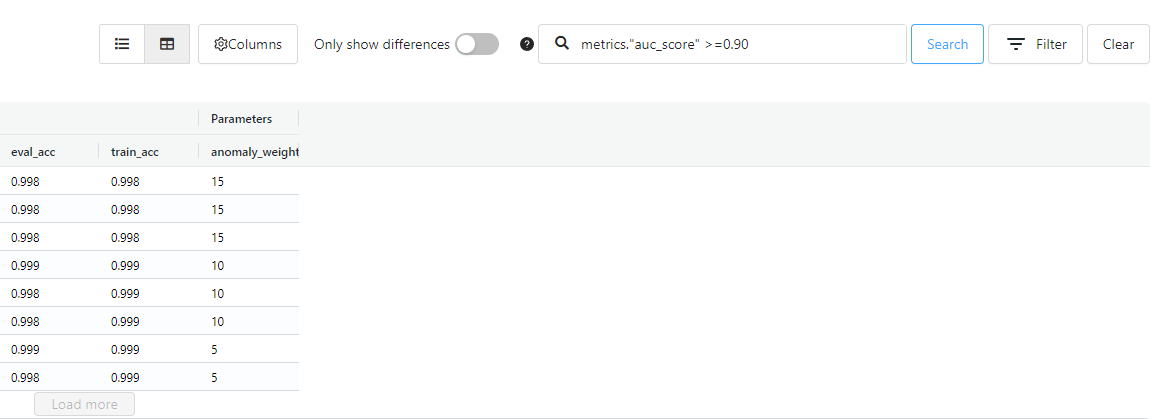

... 생략

#### guided search

앞에서 이상 가중치가 10, 15일 때 성능이 가장 좋았지만, 이상 가중치가 증가할수록 상승추세인 것 같다.


가중치를 수정하고 다시 실험해보자.

In [55]:
anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [56]:
mlflow.set_experiment('sklearn_creditcard_guided_search') # 이부분 수정
logs = []

for f in range((len(anomaly_weights))):
    fold = 1
    accuracies = []
    auc_scores = []
    
    for train, test in kfold.split(X_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param('anomaly_weight', weight)
            class_weights = {0: 1, 1: weight}
            
            sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg',
                                         class_weight=class_weights).fit(X_validate[train], y_validate[train])
            
            for h in range(40): print('-', end="")
            
            print(f'\nfold {fold}\nAnomaly Weight: {weight}')
            train_acc = sk_model.score(X_validate[train], y_validate[train])
            mlflow.log_metric('train_acc', train_acc)
            
            eval_acc = sk_model.score(X_validate[test], y_validate[test])
            preds = sk_model.predict(X_validate[test])
            mlflow.log_metric('eval_acc', eval_acc)
            
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
                
            mlflow.log_metric('auc_score', auc_score)
            print("AUC: {}\neval: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            
            log = [sk_model, X_validate[test], y_validate[test], preds]
            logs.append(log)
            
            mlflow.sklearn.log_model(sk_model, f'anom_weight_{weight}_fold_{fold}')
            fold = fold + 1
            mlflow.end_run()

2022/04/12 14:31:57 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_guided_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval: 0.9982477659015244
----------------------------------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval: 0.9985979670522257
----------------------------------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval: 0.9985979670522257
----------------------------------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval: 0.9985979670522257
----------------------------------------
fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval: 0.9947432977045734
----------------------------------------
fold 2
Anomaly Weight: 50
AUC: 0.9734640030154541
eval: 0.9943918682089029
----------------------------------------
fold 3
Anomaly Weight: 50
AUC: 0.9296190262939033
eval: 0.99509288468279
----------------------------------------
fold 4
Anomaly Weight: 50
AUC: 0.9

In [57]:
print('\nAverages: ')
print("Accuracy: ", np.mean(accuracies))
print('AUC: ', np.mean(auc_scores))
print('Best: ')
print('Accuracy: ', np.max(accuracies))
print('AUC: ', np.max(auc_scores))


Averages: 
Accuracy:  0.9824751101994336
AUC:  0.9395730983624768
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9904133685136324


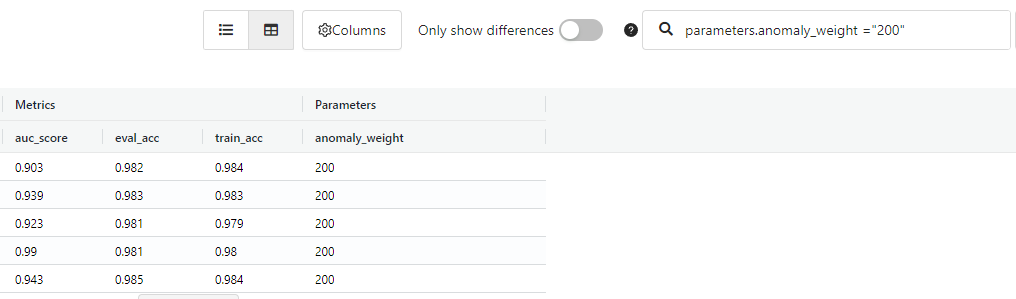